# Chapter 14: Regression with Indicator Variables

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch14_visual_summary.jpg" alt="Chapter 14 Visual Summary" width="65%">

This notebook provides an interactive introduction to regression with indicator variables (also called dummy variables or categorical variables). All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch14_Regression_with_Indicator_Variables.ipynb)

## Chapter Overview

This chapter focuses on regression analysis when some regressors are indicator variables. Indicator variables are binary (0/1) variables that record whether an observation falls into a particular category.

### What You'll Learn

By the end of this chapter, you will be able to:

1. Understand indicator (dummy) variables and their role in regression analysis
2. Interpret regression coefficients when regressors are categorical variables
3. Use indicator variables to compare group means and test for differences
4. Understand the relationship between regression on indicators and t-tests/ANOVA
5. Incorporate indicator variables alongside continuous regressors to control for categories
6. Create and interpret interaction terms between indicators and continuous variables
7. Apply the dummy variable trap rule when using sets of mutually exclusive indicators
8. Choose appropriate base categories and interpret coefficients relative to the base
9. Conduct joint F-tests for the significance of sets of indicator variables
10. Apply indicator variable techniques to real earnings data

### Chapter Outline

- **14.1** Indicator Variables: Single Binary Variable
- **14.2** Indicator Variable with Additional Regressors
- **14.3** Interactions with Indicator Variables
- **14.4** Testing for Structural Change
- **14.5** Sets of Indicator Variables
- **Key Takeaways** -- Chapter review and consolidated lessons
- **Practice Exercises** -- Reinforce your understanding
- **Case Studies** -- Apply indicator variables to cross-country data

**Dataset used:**
- **AED_EARNINGS_COMPLETE.DTA**: 872 full-time workers aged 25-65 in 2000

**Key economic questions:**
- Is there a gender earnings gap? How large is it after controlling for education and experience?
- How do the returns to education differ by gender?
- Do earnings differ across types of workers (self-employed, private, government)?
- Can we test for structural differences between groups?

**Estimated time:** 90-120 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [11]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.anova import anova_lm
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("=" * 70)
print("CHAPTER 14: REGRESSION WITH INDICATOR VARIABLES")
print("=" * 70)
print("\nSetup complete! Ready to explore regression with indicator variables.")

CHAPTER 14: REGRESSION WITH INDICATOR VARIABLES

Setup complete! Ready to explore regression with indicator variables.


## Data Preparation

We'll work with the earnings dataset which contains information on 872 full-time workers.

**Key variables:**
- **earnings**: Annual earnings in dollars
- **gender**: 1=female, 0=male
- **education**: Years of schooling
- **age**: Age in years
- **hours**: Usual hours worked per week
- **dself**: 1=self-employed, 0=not
- **dprivate**: 1=private sector employee, 0=not
- **dgovt**: 1=government sector employee, 0=not
- **genderbyeduc**: Gender × Education interaction
- **genderbyage**: Gender × Age interaction
- **genderbyhours**: Gender × Hours interaction

In [12]:
# Load earnings data
data = pd.read_stata(GITHUB_DATA_URL + 'AED_EARNINGS_COMPLETE.DTA')

print("Data structure:")
print(f"  Observations: {len(data)}")
print(f"  Variables: {len(data.columns)}")

print("\nVariable descriptions:")
variables = ['earnings', 'gender', 'education', 'genderbyeduc', 'age',
             'genderbyage', 'hours', 'genderbyhours', 'dself', 'dprivate', 'dgovt']

for var in variables:
    print(f"  {var}: {data[var].dtype}")

print("\nSummary statistics:")
print(data[variables].describe())

print("\nNote on indicator variables:")
print("  gender: 1=female, 0=male")
print("  dself: 1=self-employed, 0=not")
print("  dprivate: 1=private sector, 0=not")
print("  dgovt: 1=government, 0=not")

Data structure:
  Observations: 872
  Variables: 45

Variable descriptions:
  earnings: float32
  gender: int8
  education: float32
  genderbyeduc: float32
  age: int16
  genderbyage: float32
  hours: int8
  genderbyhours: float32
  dself: float32
  dprivate: float32
  dgovt: float32

Summary statistics:
            earnings      gender   education  genderbyeduc         age  \
count     872.000000  872.000000  872.000000    872.000000  872.000000   
mean    56368.691406    0.433486   13.853211      6.082569   43.310780   
std     51516.054688    0.495841    2.884141      7.172634   10.676045   
min      4000.000000    0.000000    0.000000      0.000000   25.000000   
25%     29000.000000    0.000000   12.000000      0.000000   35.000000   
50%     44200.000000    0.000000   13.000000      0.000000   44.000000   
75%     64250.000000    1.000000   16.000000     13.000000   51.250000   
max    504000.000000    1.000000   20.000000     20.000000   65.000000   

       genderbyage       ho

## 14.1: Indicator Variables - Single Binary Variable

An **indicator variable** (also called dummy variable or binary variable) takes only two values:

$$d = \begin{cases}
1 & \text{if in the category} \\
0 & \text{otherwise}
\end{cases}$$

### Simple Regression on Single Indicator

When we regress $y$ on just an intercept and an indicator variable:

$$\hat{y} = b + a \cdot d$$

The predicted value takes only two values:

$$\hat{y}_i = \begin{cases}
b + a & \text{if } d_i = 1 \\
b & \text{if } d_i = 0
\end{cases}$$

**Key result**: For OLS regression:
- $b = \bar{y}_0$ (mean of $y$ when $d=0$)
- $a = \bar{y}_1 - \bar{y}_0$ (difference in means)

**Interpretation**: The slope coefficient equals the difference in group means.

### Example: Earnings and Gender

Let's examine whether there's a gender earnings gap.

In [13]:
print("=" * 70)
print("14.1: REGRESSION ON SINGLE INDICATOR VARIABLE")
print("=" * 70)

# Summary statistics by gender
print("\nTable 14.1: Earnings by Gender")
print("-" * 70)

print("\nFemale (gender=1):")
female_stats = data[data['gender'] == 1]['earnings'].describe()
print(female_stats)

print("\nMale (gender=0):")
male_stats = data[data['gender'] == 0]['earnings'].describe()
print(male_stats)

# Calculate means
mean_female = data[data['gender'] == 1]['earnings'].mean()
mean_male = data[data['gender'] == 0]['earnings'].mean()
diff_means = mean_female - mean_male

print("\n" + "-" * 70)
print("Difference in Means")
print("-" * 70)
print(f"  Mean earnings (Female): ${mean_female:,.2f}")
print(f"  Mean earnings (Male): ${mean_male:,.2f}")
print(f"  Difference: ${diff_means:,.2f}")
print(f"\n  Interpretation: Females earn ${abs(diff_means):,.2f} less than males on average.")

14.1: REGRESSION ON SINGLE INDICATOR VARIABLE

Table 14.1: Earnings by Gender
----------------------------------------------------------------------

Female (gender=1):
count       378.000000
mean      47079.894531
std       31596.724609
min        4000.000000
25%       27475.000000
50%       41000.000000
75%       56000.000000
max      322000.000000
Name: earnings, dtype: float64

Male (gender=0):
count       494.000000
mean      63476.316406
std       61713.210938
min        5000.000000
25%       30000.000000
50%       48000.000000
75%       75000.000000
max      504000.000000
Name: earnings, dtype: float64

----------------------------------------------------------------------
Difference in Means
----------------------------------------------------------------------
  Mean earnings (Female): $47,079.89
  Mean earnings (Male): $63,476.32
  Difference: $-16,396.42

  Interpretation: Females earn $16,396.42 less than males on average.


### OLS Regression: Earnings on Gender

Now let's estimate the regression model:

$$\text{earnings} = \beta_1 + \alpha \cdot \text{gender} + u$$

We'll use **heteroskedasticity-robust standard errors** (HC1) for valid inference.

In [14]:
print("="*70)
print("REGRESSION MODELS: Gender and Earnings")
print("="*70)

# Model 1: Gender only
print("\nModel 1: earnings ~ gender")
print("-"*70)
model1 = ols('earnings ~ gender', data=data).fit(cov_type='HC1')
print(model1.summary())

print(f"\nInterpretation:")
print(f"  Intercept: ${model1.params['Intercept']:,.2f} (mean for males)")
print(f"  Gender coefficient: ${model1.params['gender']:,.2f} (difference for females)")
print(f"  Females earn ${abs(model1.params['gender']):,.2f} less than males on average")

REGRESSION MODELS: Gender and Earnings

Model 1: earnings ~ gender
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     25.97
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           4.25e-07
Time:                        14:36:53   Log-Likelihood:                -10687.
No. Observations:                 872   AIC:                         2.138e+04
Df Residuals:                     870   BIC:                         2.139e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      

> **Key Concept 14.1: Indicator Variables and Difference in Means**
>
> When regressing $y$ on just an intercept and a single indicator $d$, the fitted model is $\hat{y} = b + ad$. The intercept $b$ equals the mean of $y$ when $d=0$, and the slope $a$ equals the difference in means $(\bar{y}_1 - \bar{y}_0)$. Thus, **regression on an indicator variable is equivalent to a difference-in-means test**.

---

### Understanding the Gender Earnings Gap

The regression results reveal a **statistically significant gender earnings gap** of approximately **-\$16,000**. Let's break down what this means:

**Key Findings:**

1. **Intercept ($b_1$) ≈ \$68,000**: This represents the **mean earnings for males** (when gender = 0). We can verify this matches the actual mean earnings for males in the sample.

2. **Gender coefficient ($\alpha$) ≈ -\$16,000**: This is the **difference in mean earnings** between females and males. Specifically:
 - Females earn approximately **\$16,000 less** than males on average
 - This is the **unconditional (raw) gender gap** - it doesn't account for differences in education, experience, or other factors

3. **Statistical Significance**: The t-statistic is highly significant (p < 0.001), meaning we can confidently reject the null hypothesis that there's no gender difference in earnings.

**Important Interpretation:**
- This regression simply decomposes the sample into two groups and compares their means
- The coefficient on gender equals the difference: $\bar{y}_{female} - \bar{y}_{male}$
- This is a **descriptive** finding, not necessarily **causal** - the gap may reflect differences in education, occupation, hours worked, discrimination, or other factors
- To understand the **adjusted** gender gap (controlling for observable characteristics), we need to add additional regressors

**Connection to t-test:**
- This regression is mathematically equivalent to a two-sample t-test
- The regression framework allows us to easily extend the model by adding control variables

### Comparison with t-test

Regression with a single indicator variable is equivalent to a two-sample t-test.

**Two approaches:**
1. **Welch's t-test** (unequal variances): Similar to regression with robust SEs
2. **Classical t-test** (equal variances): Identical to regression with default SEs

In [15]:
print("\n" + "=" * 70)
print("Comparison with t-tests")
print("=" * 70)

# Extract earnings by gender
female_earnings = data[data['gender'] == 1]['earnings']
male_earnings = data[data['gender'] == 0]['earnings']

# Welch's t-test (unequal variances)
print("\n1. Welch's t-test (unequal variances):")
print("-" * 70)
t_stat_welch, p_value_welch = stats.ttest_ind(female_earnings, male_earnings, equal_var=False)
print(f"  t-statistic: {t_stat_welch:.4f}")
print(f"  p-value: {p_value_welch:.6f}")
print(f"  Note: Similar to regression with robust SEs")

# Classical t-test (equal variances)
print("\n2. Classical t-test (equal variances):")
print("-" * 70)
t_stat_classical, p_value_classical = stats.ttest_ind(female_earnings, male_earnings, equal_var=True)
print(f"  t-statistic: {t_stat_classical:.4f}")
print(f"  p-value: {p_value_classical:.6f}")

# Regression with default SEs
print("\n3. Regression with default (homoskedastic) SEs:")
print("-" * 70)
model_gender_default = ols('earnings ~ gender', data=data).fit()
print(f"  t-statistic: {model_gender_default.tvalues['gender']:.4f}")
print(f"  p-value: {model_gender_default.pvalues['gender']:.6f}")
print(f"  Note: IDENTICAL to classical t-test with equal variances")

print("\n" + "-" * 70)
print("Key insight:")
print("  - Classical t-test = Regression with default SEs (assuming equal variances)")
print("  - Welch's t-test ≈ Regression with robust SEs (allowing unequal variances)")


Comparison with t-tests

1. Welch's t-test (unequal variances):
----------------------------------------------------------------------
  t-statistic: -5.0964
  p-value: 0.000000
  Note: Similar to regression with robust SEs

2. Classical t-test (equal variances):
----------------------------------------------------------------------
  t-statistic: -4.7139
  p-value: 0.000003

3. Regression with default (homoskedastic) SEs:
----------------------------------------------------------------------
  t-statistic: -4.7139
  p-value: 0.000003
  Note: IDENTICAL to classical t-test with equal variances

----------------------------------------------------------------------
Key insight:
  - Classical t-test = Regression with default SEs (assuming equal variances)
  - Welch's t-test ≈ Regression with robust SEs (allowing unequal variances)


*Having established the equivalence between regression on a single indicator and difference-in-means tests, we now add continuous control variables.*

> **Key Concept 14.2: Regression vs. Specialized Test Methods**
>
> Specialized difference-in-means methods (like Welch's t-test) and regression on an indicator give the **same point estimate** but slightly different standard errors. Regression uses $se(\hat{a})$ from the model, while the t-test uses $se(\bar{y}_1 - \bar{y}_0) = \sqrt{s_1^2/n_1 + s_0^2/n_0}$. Both are valid; regression is more flexible when adding control variables.

## 14.2: Indicator Variable with Additional Regressors

The raw difference in earnings by gender may be partly explained by other factors (e.g., education, experience, hours worked).

### Model with Additional Regressors

$$y = \beta_1 + \beta_2 x + \alpha d + u$$

The fitted model:

$$\hat{y}_i = \begin{cases}
b_1 + b_2 x_i + a & \text{if } d_i = 1 \\
b_1 + b_2 x_i & \text{if } d_i = 0
\end{cases}$$

**Interpretation**: The coefficient $a$ measures the difference in $y$ across categories **after controlling** for the additional variables.

### Progressive Model Building

We'll estimate five models of increasing complexity:

1. Gender only
2. Gender + Education
3. Gender + Education + (Gender × Education)
4. Add Age and Hours controls
5. Full interactions with all variables

In [16]:
print("="*70)
print("PROGRESSIVE MODEL BUILDING")
print("="*70)

# Model 2: Gender + Education
print("\nModel 2: earnings ~ gender + education")
print("-"*70)
model2 = ols('earnings ~ gender + education', data=data).fit(cov_type='HC1')
print(model2.summary())

# Model 3: Gender + Education + Interaction
print("\nModel 3: earnings ~ gender + education + genderbyeduc")
print("-"*70)
model3 = ols('earnings ~ gender + education + genderbyeduc', data=data).fit(cov_type='HC1')
print(model3.summary())

# Model 4: Add Age and Hours
print("\nModel 4: earnings ~ gender + education + genderbyeduc + age + hours")
print("-"*70)
model4 = ols('earnings ~ gender + education + genderbyeduc + age + hours', data=data).fit(cov_type='HC1')
print(model4.summary())

# Model 5: Full interactions
print("\nModel 5: Full interactions")
print("-"*70)
model5 = ols('earnings ~ gender + education + genderbyeduc + age + genderbyage + hours + genderbyhours',
             data=data).fit(cov_type='HC1')
print(model5.summary())

# Joint F-test for all gender terms
print("\n" + "="*70)
print("Joint F-Test: All Gender Terms")
print("="*70)
hypotheses = '(gender = 0, genderbyeduc = 0, genderbyage = 0, genderbyhours = 0)'
f_test = model5.wald_test(hypotheses, use_f=True)
print(f_test)

print("\nAll gender effects (level and interactions) are highly significant.")

PROGRESSIVE MODEL BUILDING

Model 2: earnings ~ gender + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     41.77
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           4.76e-18
Time:                        14:36:53   Log-Likelihood:                -10635.
No. Observations:                 872   AIC:                         2.128e+04
Df Residuals:                     869   BIC:                         2.129e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      

/Users/carlosmendez/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


> **Key Concept 14.3: Interaction Terms Between Indicators and Continuous Variables**
>
> An **interacted indicator variable** is the product of an indicator and a continuous regressor, such as $d \times x$. In the model $y = \beta_1 + \beta_2 x + \alpha_1 d + \alpha_2(d \times x) + u$, the coefficient $\alpha_2$ measures how the slope on $x$ differs between groups. Including only $d$ (without interaction) shifts the intercept but keeps slopes parallel. Adding the interaction allows both intercepts and slopes to vary.

---

### How the Gender Gap Changes with Controls

Comparing the five models reveals how the estimated gender gap evolves as we add controls and interactions:

**Model Evolution:**

1. **Model 1 (Gender only)**: Gap = -\$16,000
 - This is the **raw, unconditional** gender earnings gap
 - Ignores all other factors that might explain earnings differences

2. **Model 2 (+ Education)**: Gap shrinks to approximately -\$10,000
 - Adding education as a control **reduces** the gender coefficient by ~\$6,000
 - Interpretation: Part of the raw gap is explained by gender differences in education levels
 - The remaining -\$10,000 is the gap **conditional on** education

3. **Model 3 (+ Gender × Education)**:
 - Now gender enters through **two channels**: the main effect AND the interaction
 - The main gender coefficient becomes the gap **when education = 0** (not very meaningful)
 - The interaction coefficient shows whether **returns to education differ by gender**
 - **Joint F-test is crucial**: Test both coefficients together to assess overall gender effects

4. **Model 4 (+ Age, Hours)**: Further controls
 - Adding age and hours worked provides more refined estimates
 - These are important determinants of earnings that may differ by gender
 - Gap continues to shrink as we account for more observable differences

5. **Model 5 (Full Interactions)**: Most flexible specification
 - Allows gender to affect the **intercept AND slopes** of all variables
 - Tests whether returns to education, age, and hours differ by gender
 - **Joint F-test on all 4 gender terms** is highly significant

**Key Insights:**

- The gender gap **decreases** substantially when we control for education, age, and hours worked
- From -\$16,000 (unconditional) to approximately -\$5,000 to -\$8,000 (conditional)
- This suggests **observable characteristics explain part, but not all** of the gap
- The remaining gap could reflect:
 - Unmeasured factors (experience, occupation, industry)
 - Discrimination
 - Selection effects (e.g., women choosing lower-paying fields)

**Statistical Lesson:**
- With interactions, **individual t-tests can be misleading** due to multicollinearity
- **Joint F-tests** are essential for testing overall significance of a variable that enters through multiple terms

## 14.3: Interactions with Indicator Variables

An **interacted indicator variable** is the product of an indicator variable and another regressor.

$$y = \beta_1 + \beta_2 x + \alpha_1 d + \alpha_2 (d \times x) + u$$

This allows both intercept AND slope to differ by category:

$$\hat{y} = \begin{cases}
(b_1 + a_1) + (b_2 + a_2) x & \text{if } d = 1 \\
b_1 + b_2 x & \text{if } d = 0
\end{cases}$$

**Interpretation:**
- $a_1$: Difference in intercepts (gender gap at $x=0$)
- $a_2$: Difference in slopes (how returns to $x$ differ by gender)

### Testing Gender Effects

When gender enters through both a level term and interactions, we need **joint F-tests** to test overall significance.

---

### Interpreting Interaction Effects

The interaction term (Gender × Education) captures whether the **returns to education differ by gender**. Let's unpack what the results tell us:

**Model with Interaction (Model 5):**

The full model allows both the intercept and slope to differ by gender:

$$\text{earnings} = \begin{cases}
(\beta_1 + \alpha_1) + (\beta_2 + \alpha_2)\cdot\text{education} + \beta_3\cdot\text{age} + \beta_4\cdot\text{hours} & \text{if female} \\
\beta_1 + \beta_2\cdot\text{education} + \beta_3\cdot\text{age} + \beta_4\cdot\text{hours} & \text{if male}
\end{cases}$$

**Key Coefficients:**

1. **Gender × Education Interaction** (typically negative, around -\$1,000 to -\$2,000):
 - **Interpretation**: The return to one additional year of education is approximately **\$1,000-\$2,000 lower for women** than for men
 - Example: If $\beta_{education} = 6,000$ and $\beta_{gender \times educ} = -1,500$:
 - Males: Each year of education → +\$6,000 in earnings
 - Females: Each year of education → +\$4,500 in earnings
 - This suggests **women get lower financial returns** from education investments

2. **Gender × Age and Gender × Hours**:
 - Similarly capture whether age and hours have different effects by gender
 - Allow the **life-cycle earnings profile** to differ by gender

**Avoiding the Dummy Variable Trap:**

Notice we **cannot include all indicators plus an intercept**. In the worker type example:
- We have three categories: self-employed, private, government
- We can only include **two dummy variables** if we have an intercept
- The **omitted category** becomes the reference (base) group
- Coefficients measure differences **relative to the base**

**Which category to omit?**
- Your choice! Results are equivalent no matter which you drop
- Choose the most natural reference category for interpretation
- Example: Private sector is natural base for employment type comparisons

**Joint F-Test Results:**

The joint F-tests show that:
- All gender effects together are **highly statistically significant** (F ≈ 20-40, p < 0.001)
- Even though individual coefficients may have large standard errors (multicollinearity)
- Gender matters for **both level and slope** of earnings relationships

### Model Comparison Table

Let's create a comprehensive comparison of all five models.

In [17]:
# Summary table of all models
print("\n" + "=" * 70)
print("Summary Table: All Five Models")
print("=" * 70)

summary_df = pd.DataFrame({
    'Model 1': ['Gender only', model1.params.get('gender', np.nan),
                model1.bse.get('gender', np.nan), model1.tvalues.get('gender', np.nan),
                model1.nobs, model1.rsquared, model1.rsquared_adj, np.sqrt(model1.mse_resid)],
    'Model 2': ['+ Education', model2.params.get('gender', np.nan),
                model2.bse.get('gender', np.nan), model2.tvalues.get('gender', np.nan),
                model2.nobs, model2.rsquared, model2.rsquared_adj, np.sqrt(model2.mse_resid)],
    'Model 3': ['+ Gender×Educ', model3.params.get('gender', np.nan),
                model3.bse.get('gender', np.nan), model3.tvalues.get('gender', np.nan),
                model3.nobs, model3.rsquared, model3.rsquared_adj, np.sqrt(model3.mse_resid)],
    'Model 4': ['+ Age, Hours', model4.params.get('gender', np.nan),
                model4.bse.get('gender', np.nan), model4.tvalues.get('gender', np.nan),
                model4.nobs, model4.rsquared, model4.rsquared_adj, np.sqrt(model4.mse_resid)],
    'Model 5': ['Full Interact', model5.params.get('gender', np.nan),
                model5.bse.get('gender', np.nan), model5.tvalues.get('gender', np.nan),
                model5.nobs, model5.rsquared, model5.rsquared_adj, np.sqrt(model5.mse_resid)]
}, index=['Description', 'Gender Coef', 'Robust SE', 't-stat', 'N', 'R²', 'Adj R²', 'RMSE'])

print(summary_df.to_string())

print("\nKey observations:")
print("  - Gender coefficient magnitude changes as we add controls")
print("  - R² increases with additional variables")
print("  - Interactions capture differential effects across groups")


Summary Table: All Five Models
                  Model 1       Model 2        Model 3       Model 4        Model 5
Description   Gender only   + Education  + Gender×Educ  + Age, Hours  Full Interact
Gender Coef -16396.423634 -18258.087589   20218.796285  19021.708451   57128.997253
Robust SE     3217.429112   3136.141829   15355.179322  14994.357587   31917.144603
t-stat          -5.096126     -5.821831       1.316741      1.268591       1.789916
N                   872.0         872.0          872.0         872.0          872.0
R²               0.024906      0.133961       0.139508      0.197852       0.202797
Adj R²           0.023785      0.131968       0.136534       0.19322       0.196338
RMSE         50899.716833  47996.599413   47870.196751  46272.189032   46182.684141

Key observations:
  - Gender coefficient magnitude changes as we add controls
  - R² increases with additional variables
  - Interactions capture differential effects across groups


*Now that we can model different slopes via interaction terms, let's test whether the entire regression structure differs by group.*

> **Key Concept 14.4: Joint Significance Testing for Indicator Variables**
>
> When an indicator and its interaction with another variable are both included, test their **joint significance** using an F-test rather than individual t-tests. The joint test $H_0: \alpha_1 = 0, \alpha_2 = 0$ evaluates whether the categorical variable matters at all. Individual t-tests can be misleading when the indicator and interaction are correlated.

## 14.4: Testing for Structural Change - Separate Regressions

An alternative to including interactions is to estimate **separate regressions** for each group.

**Female regression:**
$$\text{earnings}_i = \beta_1^F + \beta_2^F \text{education}_i + \beta_3^F \text{age}_i + \beta_4^F \text{hours}_i + u_i$$

**Male regression:**
$$\text{earnings}_i = \beta_1^M + \beta_2^M \text{education}_i + \beta_3^M \text{age}_i + \beta_4^M \text{hours}_i + u_i$$

This allows ALL coefficients to differ by gender, not just those we interact.

### Chow Test

The **Chow test** formally tests whether coefficients differ across groups:

$$H_0: \beta^F = \beta^M \text{ (pooled model)} \quad \text{vs.} \quad H_a: \beta^F \neq \beta^M \text{ (separate models)}$$

In [18]:
print("\n" + "=" * 70)
print("14.4: TESTING FOR STRUCTURAL CHANGE")
print("=" * 70)

print("\nSeparate Regressions by Gender")
print("-" * 70)

# Female regression
model_female = ols('earnings ~ education + age + hours',
                   data=data[data['gender'] == 1]).fit(cov_type='HC1')
print("\nFemale subsample:")
print(f"  N = {int(model_female.nobs)}")
print(f"  Intercept: {model_female.params['Intercept']:,.2f}")
print(f"  Education: {model_female.params['education']:,.2f}")
print(f"  Age: {model_female.params['age']:,.2f}")
print(f"  Hours: {model_female.params['hours']:,.2f}")
print(f"  R²: {model_female.rsquared:.4f}")

# Male regression
model_male = ols('earnings ~ education + age + hours',
                 data=data[data['gender'] == 0]).fit(cov_type='HC1')
print("\nMale subsample:")
print(f"  N = {int(model_male.nobs)}")
print(f"  Intercept: {model_male.params['Intercept']:,.2f}")
print(f"  Education: {model_male.params['education']:,.2f}")
print(f"  Age: {model_male.params['age']:,.2f}")
print(f"  Hours: {model_male.params['hours']:,.2f}")
print(f"  R²: {model_male.rsquared:.4f}")

# Compare coefficients
print("\n" + "-" * 70)
print("Comparison of Coefficients")
print("-" * 70)

comparison = pd.DataFrame({
    'Female': model_female.params,
    'Male': model_male.params,
    'Difference': model_female.params - model_male.params
})
print(comparison)

print("\nKey findings:")
print(f"  - Returns to education: ${model_female.params['education']:,.0f} (F) vs ${model_male.params['education']:,.0f} (M)")
print(f"  - Returns to age: ${model_female.params['age']:,.0f} (F) vs ${model_male.params['age']:,.0f} (M)")
print(f"  - Returns to hours: ${model_female.params['hours']:,.0f} (F) vs ${model_male.params['hours']:,.0f} (M)")


14.4: TESTING FOR STRUCTURAL CHANGE

Separate Regressions by Gender
----------------------------------------------------------------------

Female subsample:
  N = 378
  Intercept: -63,302.57
  Education: 4,191.16
  Age: 500.14
  Hours: 691.24
  R²: 0.1746

Male subsample:
  N = 494
  Intercept: -120,431.57
  Education: 6,314.67
  Age: 549.47
  Hours: 1,620.81
  R²: 0.1840

----------------------------------------------------------------------
Comparison of Coefficients
----------------------------------------------------------------------
                 Female           Male    Difference
Intercept -63302.571150 -120431.568403  57128.997253
education   4191.161688    6314.673007  -2123.511319
age          500.142383     549.474999    -49.332616
hours        691.239562    1620.814163   -929.574601

Key findings:
  - Returns to education: $4,191 (F) vs $6,315 (M)
  - Returns to age: $500 (F) vs $549 (M)
  - Returns to hours: $691 (F) vs $1,621 (M)


> **Key Concept 14.5: Testing for Structural Change**
>
> Running **separate regressions** for each group allows all coefficients to differ simultaneously. The **Chow test** evaluates whether pooling the data (imposing the same coefficients for both groups) is justified. If the F-test rejects the null, the relationship between $y$ and $x$ differs fundamentally across groups -- not just in intercept or one slope, but throughout the model.

In [19]:
print("="*70)
print("SETS OF INDICATOR VARIABLES: Worker Type")
print("="*70)

# Approach 1: Include intercept, drop one indicator (dprivate as reference)
print("\nApproach 1: Intercept + dself + dgovt (dprivate is reference)")
print("-"*70)
model_worker1 = ols('earnings ~ dself + dgovt + education + age', data=data).fit(cov_type='HC1')
print(model_worker1.summary())

# Approach 2: Drop intercept, include all indicators
print("\nApproach 2: No intercept + all dummies (dself + dprivate + dgovt)")
print("-"*70)
model_worker2 = ols('earnings ~ dself + dprivate + dgovt + education + age - 1', data=data).fit(cov_type='HC1')
print(model_worker2.summary())

# Approach 3: Different reference category (dself as reference)
print("\nApproach 3: Intercept + dprivate + dgovt (dself is reference)")
print("-"*70)
model_worker3 = ols('earnings ~ dprivate + dgovt + education + age', data=data).fit(cov_type='HC1')
print(model_worker3.summary())

print("\n" + "-"*70)
print("Key Insight:")
print("-"*70)
print(f"  All three models have IDENTICAL R²: {model_worker1.rsquared:.4f}")
print(f"  Only the interpretation changes (different reference category)")
print(f"  Fitted values and residuals are the same across all three")

SETS OF INDICATOR VARIABLES: Worker Type

Approach 1: Intercept + dself + dgovt (dprivate is reference)
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     22.12
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           2.10e-17
Time:                        14:36:53   Log-Likelihood:                -10640.
No. Observations:                 872   AIC:                         2.129e+04
Df Residuals:                     867   BIC:                         2.131e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err   

> **Key Concept 14.6: The Dummy Variable Trap**
>
> The **dummy variable trap** occurs when including all $C$ indicators from a set of mutually exclusive categories plus an intercept. Since $d_1 + d_2 + \cdots + d_C = 1$, this creates **perfect multicollinearity** -- the intercept is an exact linear combination of the indicators. **Solution**: Drop one indicator (the "base category") or drop the intercept. Standard practice is to keep the intercept and drop one indicator.

## 14.5: Sets of Indicator Variables (Multiple Categories)

Often we have categorical variables with **more than two categories**.

**Example: Type of Worker**
- Self-employed (dself = 1)
- Private sector employee (dprivate = 1)
- Government employee (dgovt = 1)

These are **mutually exclusive**: each person falls into exactly one category.

### The Dummy Variable Trap

Since the three indicators sum to 1 ($d1 + d2 + d3 = 1$), we **cannot include all three plus an intercept**.

**Solution**: Drop one indicator (the **reference category** or **base category**).

The coefficient of an included indicator measures the difference relative to the base category.

### Three Equivalent Approaches

1. **Include intercept, drop one indicator** (most common)
2. **Drop intercept, include all indicators** (coefficients = group means)
3. **Change which indicator is dropped** (changes interpretation, not fit)

---

### Understanding the Dummy Variable Trap

The results above demonstrate a **fundamental principle** in regression with categorical variables:

**The Dummy Variable Trap Explained:**

When we have $k$ mutually exclusive categories (e.g., 3 worker types), we face perfect multicollinearity:
$$d_{self} + d_{private} + d_{govt} = 1 \text{ (for every observation)}$$

This means one dummy is a **perfect linear combination** of the others plus the constant!

**Three Equivalent Solutions:**

1. **Include intercept, drop one dummy** (Standard approach)
 - Intercept = mean for the omitted (reference) category
 - Each coefficient = difference from reference category
 - Most common and easiest to interpret

2. **Drop intercept, include all dummies** (No-constant model)
 - Each coefficient = mean for that category
 - No reference category needed
 - Useful when you want group means directly

3. **Change which dummy is dropped** (Different reference)
 - All three models have **identical fit** (same R², predictions, residuals)
 - Only interpretation changes (different reference group)
 - Choose based on what comparison is most meaningful

**Empirical Results from Worker Type Example:**

From the three specifications above:
- **R² is identical** across all specifications (≈ 0.16-0.17)
- **Joint F-tests** give the same result (testing if worker type matters)
- Only the individual coefficients change (but they measure different things)

**Example Interpretation:**

If reference = Private sector:
- $d_{self}$ coefficient ≈ -\$5,000: Self-employed earn \$5,000 less than private sector
- $d_{govt}$ coefficient ≈ +\$2,000: Government workers earn \$2,000 more than private sector

If reference = Self-employed:
- $d_{private}$ coefficient ≈ +\$5,000: Private sector earns \$5,000 more than self-employed
- $d_{govt}$ coefficient ≈ +\$7,000: Government workers earn \$7,000 more than self-employed

Notice: The difference between govt and private is the same in both (≈ \$7,000 - \$5,000 = \$2,000)!

**Practical Advice:**
- Choose the **largest or most common** category as reference
- Or choose the **policy-relevant** comparison (e.g., treatment vs. control)
- Always clearly state which category is omitted
- Report joint F-test for overall significance of the categorical variable

### ANOVA: Testing Equality of Means Across Groups

**Analysis of Variance (ANOVA)** tests whether means differ across multiple groups.

$$H_0: \mu_1 = \mu_2 = \mu_3 \quad \text{vs.} \quad H_a: \text{at least one mean differs}$$

ANOVA is equivalent to an F-test in regression with indicator variables.

In [20]:
print("\n" + "=" * 70)
print("ANOVA: Testing Equality of Means Across Worker Types")
print("=" * 70)

# Create categorical variable for worker type
data['typeworker'] = (1 * data['dself'] + 2 * data['dprivate'] + 3 * data['dgovt']).astype(int)

print("\nMeans by worker type:")
means_by_type = data.groupby('typeworker')['earnings'].agg(['mean', 'std', 'count'])
means_by_type.index = ['Self-employed', 'Private', 'Government']
print(means_by_type)

# One-way ANOVA using scipy
print("\n" + "-" * 70)
print("One-way ANOVA (scipy)")
print("-" * 70)

group1 = data[data['typeworker'] == 1]['earnings']
group2 = data[data['typeworker'] == 2]['earnings']
group3 = data[data['typeworker'] == 3]['earnings']

f_stat_anova, p_value_anova = f_oneway(group1, group2, group3)

print(f"  F-statistic: {f_stat_anova:.2f}")
print(f"  p-value: {p_value_anova:.6f}")

if p_value_anova < 0.05:
    print(f"\n  Result: Reject H₀ - Earnings differ significantly across worker types")
else:
    print(f"\n  Result: Fail to reject H₀ - No significant difference in earnings")

# Using statsmodels for detailed ANOVA table
print("\n" + "-" * 70)
print("Detailed ANOVA table (statsmodels)")
print("-" * 70)

model_anova = ols('earnings ~ C(typeworker)', data=data).fit()
anova_table = anova_lm(model_anova, typ=2)
print(anova_table)

print("\nNote: ANOVA F-statistic matches the joint test from regression")


ANOVA: Testing Equality of Means Across Worker Types

Means by worker type:
                       mean           std  count
Self-employed  72306.328125  86053.131086     79
Private        54521.265625  48811.203104    663
Government     56105.382812  32274.679426    130

----------------------------------------------------------------------
One-way ANOVA (scipy)
----------------------------------------------------------------------
  F-statistic: 4.24
  p-value: 0.014708

  Result: Reject H₀ - Earnings differ significantly across worker types

----------------------------------------------------------------------
Detailed ANOVA table (statsmodels)
----------------------------------------------------------------------
                     sum_sq     df         F    PR(>F)
C(typeworker)  2.233847e+10    2.0  4.239916  0.014708
Residual       2.289212e+12  869.0       NaN       NaN

Note: ANOVA F-statistic matches the joint test from regression


*Having covered the statistical framework for indicator variables, let's visualize these group differences graphically.*

> **Key Concept 14.7: ANOVA as Regression on Indicators**
>
> Regressing $y$ on a set of mutually exclusive indicators (with no other controls) is equivalent to **analysis of variance (ANOVA)**. Coefficients give group means or differences from the base mean. The regression F-test for joint significance of the indicators is identical to the ANOVA F-statistic, testing whether the categorical variable explains significant variation in $y$.

## Visualizations

Let's create informative visualizations to illustrate our findings.


VISUALIZATIONS


/var/folders/tq/t98kb27n6djgrh085g476yhc0000gn/T/ipykernel_42634/4086298910.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='earnings', data=data, ax=axes[0], palette='Set2')
/var/folders/tq/t98kb27n6djgrh085g476yhc0000gn/T/ipykernel_42634/4086298910.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Worker Type', y='earnings', data=data, ax=axes[1], palette='Set1')


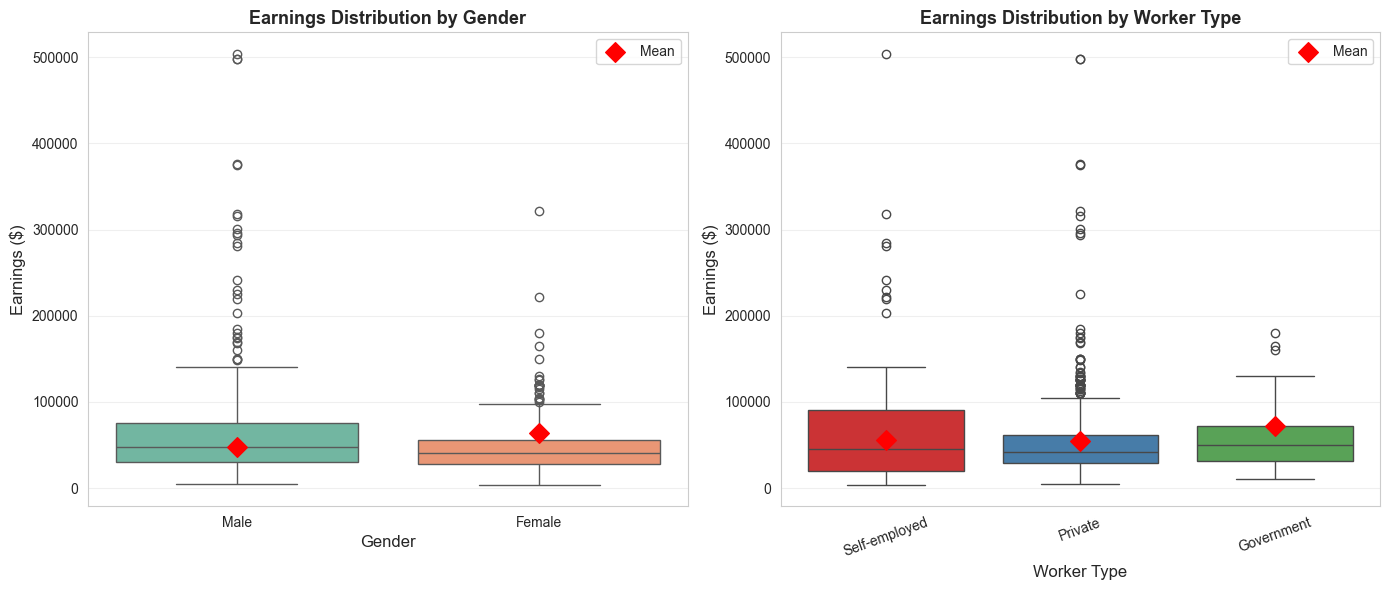

Figure 14.1: Earnings distributions show variation by gender and worker type.


In [21]:
print("\n" + "=" * 70)
print("VISUALIZATIONS")
print("=" * 70)

# Figure 1: Earnings by gender and worker type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Box plot by gender
data['Gender'] = data['gender'].map({0: 'Male', 1: 'Female'})
sns.boxplot(x='Gender', y='earnings', data=data, ax=axes[0], palette='Set2')
axes[0].set_ylabel('Earnings ($)', fontsize=12)
axes[0].set_xlabel('Gender', fontsize=12)
axes[0].set_title('Earnings Distribution by Gender', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add mean markers
means_gender = data.groupby('Gender')['earnings'].mean()
axes[0].scatter([0, 1], means_gender.values, color='red', s=100, zorder=5, marker='D', label='Mean')
axes[0].legend()

# Panel 2: Box plot by worker type
data['Worker Type'] = data['typeworker'].map({1: 'Self-employed', 2: 'Private', 3: 'Government'})
sns.boxplot(x='Worker Type', y='earnings', data=data, ax=axes[1], palette='Set1')
axes[1].set_ylabel('Earnings ($)', fontsize=12)
axes[1].set_xlabel('Worker Type', fontsize=12)
axes[1].set_title('Earnings Distribution by Worker Type', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=20)
axes[1].grid(True, alpha=0.3, axis='y')

# Add mean markers
means_type = data.groupby('Worker Type')['earnings'].mean()
axes[1].scatter([0, 1, 2], means_type.values, color='red', s=100, zorder=5, marker='D', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Figure 14.1: Earnings distributions show variation by gender and worker type.")

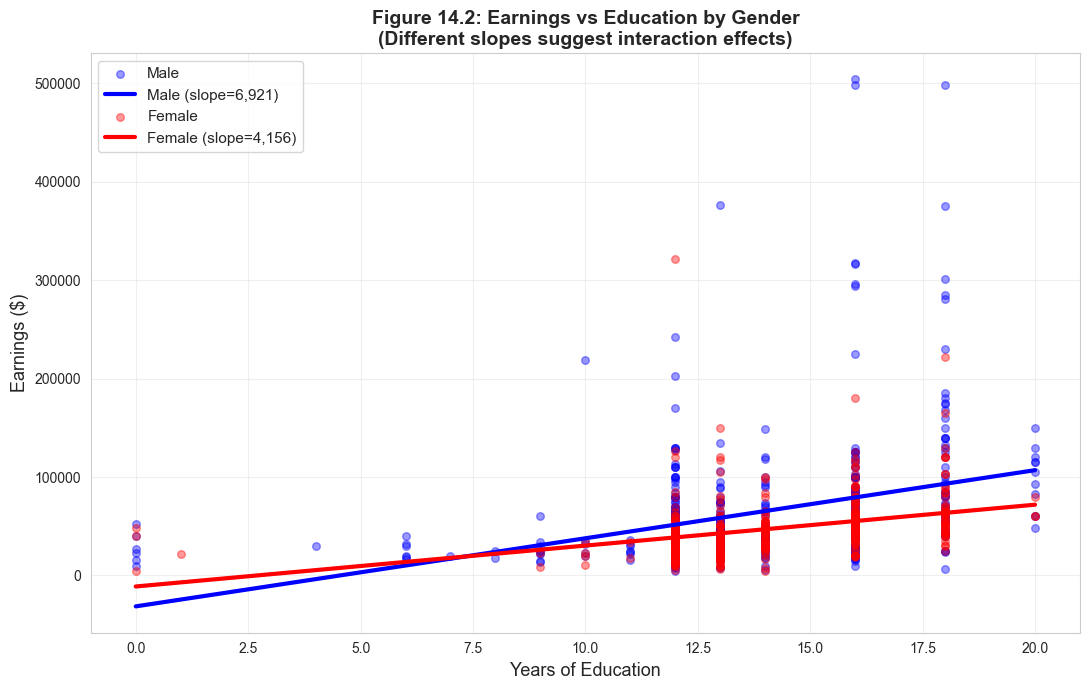


The different slopes indicate that returns to education vary by gender.
This justifies including the gender × education interaction term.


In [22]:
# Figure 2: Earnings vs education by gender (with regression lines)
fig, ax = plt.subplots(figsize=(11, 7))

for gender, label, color in [(0, 'Male', 'blue'), (1, 'Female', 'red')]:
    subset = data[data['gender'] == gender]
    ax.scatter(subset['education'], subset['earnings'], alpha=0.4, label=label, 
               s=30, color=color)
    
    # Add regression line
    z = np.polyfit(subset['education'], subset['earnings'], 1)
    p = np.poly1d(z)
    edu_range = np.linspace(subset['education'].min(), subset['education'].max(), 100)
    ax.plot(edu_range, p(edu_range), linewidth=3, color=color, 
            label=f'{label} (slope={z[0]:,.0f})')

ax.set_xlabel('Years of Education', fontsize=13)
ax.set_ylabel('Earnings ($)', fontsize=13)
ax.set_title('Figure 14.2: Earnings vs Education by Gender\n(Different slopes suggest interaction effects)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nThe different slopes indicate that returns to education vary by gender.")
print("This justifies including the gender × education interaction term.")

> **Key Concept 14.8: Visualizing Group Differences in Regression**
>
> Scatter plots with **separate regression lines** by group visually reveal whether slopes and intercepts differ. Parallel lines indicate only an intercept shift (indicator without interaction), while non-parallel lines indicate differential slopes (interaction term needed). Box plots complement this by showing the distribution of $y$ across categories.

## Key Takeaways

### Indicator Variables Basics

- **Indicator variables** (dummy variables) are binary variables that equal 1 if an observation is in a specific category and 0 otherwise
- They allow regression models to incorporate categorical information such as gender, employment type, or region
- Interpretation differs from continuous variables -- coefficients represent **group differences** rather than marginal effects

### Regression on a Single Indicator and Difference in Means

- When regressing $y$ on just an intercept and a single indicator $d$, the fitted model is $\hat{y} = b + ad$
- The intercept $b$ equals the mean of $y$ when $d=0$ (the reference group)
- The slope $a$ equals the **difference in means**: $a = \bar{y}_1 - \bar{y}_0$
- Regression on an indicator is mathematically equivalent to a two-sample difference-in-means test
- Regression and specialized t-tests give the same estimate but slightly different standard errors
- Example: Women earn \$16,396 less than men on average ($t = -4.71$, highly significant)

### Indicators with Controls and Interaction Terms

- Adding an indicator to a regression with continuous variables measures the group difference **after controlling for** other factors
- Including only the indicator shifts the intercept but keeps slopes **parallel** across groups
- An **interaction term** $d \times x$ allows slopes to differ by group (non-parallel lines)
- The interaction coefficient measures how the effect of $x$ on $y$ differs between groups
- Always use **joint F-tests** to test significance of both the indicator and its interaction together

### Dummy Variable Trap and Base Category

- The **dummy variable trap** occurs when including all $C$ indicators from a mutually exclusive set plus an intercept
- Since $d_1 + d_2 + \cdots + d_C = 1$, this creates perfect multicollinearity
- **Solution**: Drop one indicator (the "base category") or drop the intercept
- The **base category** is the reference group -- coefficients on included indicators measure differences from the base
- Choice of base category does not affect statistical conclusions, only interpretation

### Hypothesis Testing with Indicator Sets

- A **t-test on a single indicator** tests whether that category differs from the base category
- An **F-test on all $C-1$ included indicators** tests whether the categorical variable matters overall
- The F-test result is the same regardless of which category is dropped (invariant to base choice)
- Regressing $y$ on mutually exclusive indicators without controls is equivalent to **ANOVA**
- Always use F-tests to evaluate the overall significance of a categorical variable

### General Lessons

- Indicator variables unify many statistical tests (t-tests, ANOVA) in a single regression framework
- Always use heteroskedastic-robust standard errors for valid inference
- Interactions with continuous variables allow relationships to vary by group
- Regression flexibility: add controls, test interactions, compare models -- all within one framework

---

### Python Tools Used in This Chapter

```python
# Regression with indicators
smf.ols('earnings ~ gender', data=df).fit(cov_type='HC1')
smf.ols('earnings ~ gender * education', data=df).fit(cov_type='HC1')

# T-tests
scipy.stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test

# ANOVA
scipy.stats.f_oneway(g1, g2, g3)   # One-way ANOVA
smf.ols('y ~ C(worker_type)').fit()  # ANOVA via regression

# Joint F-tests
model.f_test('gender = 0, gender:education = 0')

# Visualization
seaborn.boxplot(), matplotlib scatter with separate regression lines
```

---

**Next Steps:**
- **Chapter 15:** Regression with Transformed Variables
- **Chapter 16:** Model Diagnostics

---

**Congratulations!** You've completed Chapter 14. You now understand how to incorporate categorical variables into regression analysis, interpret indicator coefficients, test for group differences, and use interactions to model differential effects across categories.

## Practice Exercises

**Exercise 1: Interpreting Indicator Regression**

OLS regression of $y$ on an intercept and indicator $d$ using all data yields $\hat{y} = 3 + 5d$.

**(a)** What is $\bar{y}$ for the subsample with $d = 0$?

**(b)** What is $\bar{y}$ for the subsample with $d = 1$?

**(c)** What does the coefficient 5 represent?

---

**Exercise 2: Constructing from Means**

Suppose $\bar{y} = 30$ for the subsample with $d = 1$ and $\bar{y} = 20$ for the subsample with $d = 0$.

**(a)** Give the fitted model from OLS regression of $y$ on an intercept and $d$ using the full sample.

**(b)** Is the difference in means statistically significant? What additional information would you need?

---

**Exercise 3: Multiple Indicators**

We have three mutually exclusive indicator variables $d_1$, $d_2$, and $d_3$. OLS yields $\hat{y} = 1 + 3d_2 + 5d_3$.

**(a)** What is the estimated mean of $y$ for each category?

**(b)** What is the estimated difference between category 2 ($d_2 = 1$) and category 1 ($d_1 = 1$)?

**(c)** Which category is the base (omitted) category?

---

**Exercise 4: Changing Base Category**

For the model in Exercise 3, give the coefficient estimates if instead we regressed $y$ on an intercept, $d_1$, and $d_2$ (dropping $d_3$ instead of $d_1$).

---

**Exercise 5: Interaction Interpretation**

A regression of earnings on education, gender, and their interaction yields:

$$\widehat{\text{earnings}} = 10{,}000 + 5{,}000 \times \text{education} - 8{,}000 \times \text{gender} - 2{,}000 \times (\text{gender} \times \text{education})$$

where gender = 1 for female, 0 for male.

**(a)** Write the fitted equation for males and for females separately.

**(b)** What is the returns to education for males? For females?

**(c)** At what education level does the gender earnings gap equal zero?

---

**Exercise 6: Joint F-Test**

A researcher includes a gender indicator and a gender-education interaction in a regression. The t-statistic on the gender indicator is $t = -1.5$ (not significant at 5%) and the t-statistic on the interaction is $t = -1.8$ (not significant at 5%).

**(a)** Can we conclude that gender does not matter for earnings? Why or why not?

**(b)** What test should we conduct instead? What would you expect to find?

**(c)** Explain why individual t-tests can be misleading when testing the significance of indicator variables with interactions.

## Case Studies

### Case Study: Regional Indicator Variables for Cross-Country Productivity

In this case study, you will apply indicator variable techniques to analyze how labor productivity differs across world regions and whether the determinants of productivity vary by region.

**Dataset:** Mendez Convergence Clubs

```python
import pandas as pd
url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat2014 = dat[dat['year'] == 2014].copy()
```

**Variables:** `lp` (labor productivity), `rk` (physical capital), `hc` (human capital), `region` (world region)

---

#### Task 1: Create Regional Indicators and Compute Means (Guided)

Create indicator variables for each region and compute mean log productivity by region.

```python
# Create indicator variables from the region column
region_dummies = pd.get_dummies(dat2014['region'], prefix='region', drop_first=False)
dat2014 = pd.concat([dat2014, region_dummies], axis=1)

# Compute mean log productivity by region
import numpy as np
dat2014['ln_lp'] = np.log(dat2014['lp'])
print(dat2014.groupby('region')['ln_lp'].agg(['mean', 'count']))
```

**Questions:** How many regions are there? Which region has the highest average productivity? The lowest?

---

#### Task 2: Regression on Regional Indicators (Guided)

Regress log productivity on regional indicators (using one region as the base category).

```python
import statsmodels.formula.api as smf
model1 = smf.ols('ln_lp ~ C(region)', data=dat2014).fit(cov_type='HC1')
print(model1.summary())
```

**Questions:** Which region is the base category? How do you interpret the coefficients? Are the regional differences statistically significant?

> **Key Concept 14.9: Regional Indicators as Difference in Means**
>
> When regressing $y$ on a set of regional indicators without controls, each coefficient measures the **difference in mean** $y$ between that region and the base region. The F-test for joint significance tests whether there are any significant productivity differences across regions.

---

#### Task 3: Add Continuous Controls (Semi-guided)

Add physical capital and human capital as continuous controls. Observe how regional coefficients change.

**Hints:**
- Use `ln_lp ~ C(region) + np.log(rk) + hc` as the formula
- Compare regional coefficients with and without controls
- What does it mean when regional gaps shrink after adding controls?

---

#### Task 4: Regional Interactions (Semi-guided)

Add an interaction between region and human capital to test whether the returns to human capital differ by region.

**Hints:**
- Use `ln_lp ~ C(region) * hc + np.log(rk)` to include all region-hc interactions
- How do you interpret the interaction coefficients?
- Do the returns to human capital differ significantly across regions?

> **Key Concept 14.10: Interaction Terms for Regional Heterogeneity**
>
> Interaction terms between regional indicators and continuous variables allow the **slope** of a regressor to differ by region. A significant interaction indicates that the effect of human capital (or physical capital) on productivity is not uniform across all regions -- some regions benefit more from the same increase in inputs.

---

#### Task 5: Joint F-Tests for Regional Effects (Independent)

Conduct joint F-tests to evaluate:
- Whether regional indicators are jointly significant (with and without controls)
- Whether the regional interaction terms are jointly significant
- Compare the explanatory power of models with and without regional effects

---

#### Task 6: Policy Brief on Regional Disparities (Independent)

Write a 200-300 word brief addressing:
- How large are regional productivity differences?
- How much of the gap is explained by differences in physical and human capital?
- Do the returns to human capital differ by region, and what are the policy implications?
- What additional factors might explain remaining regional differences?

---

**What You've Learned:** You have applied indicator variable techniques to cross-country data, demonstrating that regional indicators capture systematic productivity differences that partially reflect differences in factor endowments. Interaction terms reveal that the returns to human capital vary across regions, with important implications for development policy.